<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [23]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
import struct

In [140]:
object_name = "Sun"
# 定义要读取的文件名
file_name = 'C:\\Users\\11020\\Downloads\\%s.txt'%(object_name)

# 用于存储从文件中读取的行的列表
lines = []

try:
    # 打开文件并逐行读取
    # 'r' 表示只读模式
    # 'with' 语句确保文件在使用后会被正确关闭
    with open(file_name, 'r') as f:
        lines = f.readlines()
    print(f"成功读取文件: {file_name}")
except FileNotFoundError:
    print(f"错误：找不到文件 '{file_name}'。请确保该文件和您的Notebook在同一个目录下。")

成功读取文件: C:\Users\11020\Downloads\Sun.txt


In [141]:
# 用于存储提取数据的列表
dates = []
ras = []
decs = []
d_ang = []

# 标志位，用于确定我们是否在数据块内
in_ephemeris = False

# 只有在成功读取文件后才进行处理
if lines:
    for line in lines:
        # 检查数据块的开始标记
        if '$$SOE' in line:
            in_ephemeris = True
            continue
        # 检查数据块的结束标记
        if '$$EOE' in line:
            in_ephemeris = False
            break
    
        # 如果在数据块内，则用固定宽度切片方法解析
        if in_ephemeris:
            # 文件使用固定宽度列。根据字符位置（索引）进行切片比正则表达式更可靠。
            # 经分析，各列的索引范围如下 (从0开始计数):
            #  - 时间日期 (DateTime): [1:21]
            #  - 赤经 (R.A.):       [25:37]
            #  - 赤纬 (Dec.):       [38:50]
            try:
                # 切片并用 .strip() 去除前后的多余空格
                date_str = line[1:21].strip()
                ra_str = line[25:37].strip()
                dec_str = line[38:50].strip()
                diam_ang = line[67:76].strip()

                # 确保我们提取到了有效数据再添加进列表
                if date_str and ra_str and dec_str:
                    dates.append(date_str)
                    ras.append(ra_str)
                    decs.append(dec_str)
                    d_ang.append(diam_ang)
            except IndexError:
                # 如果某一行太短或格式不符，此异常会捕获错误并跳过该行
                print(f"跳过格式不正确或过短的行: {line.strip()}")
                continue

    # 只有在提取到数据后才创建DataFrame
    if dates:
        # 使用提取的数据创建Pandas DataFrame
        df = pd.DataFrame({
            'DateTime_UT': dates,
            'RA_hms': ras,
            'Dec_dms': decs,
            'Diameter_ang':d_ang
        })
        print("\n成功提取的原始数据:")
        display(df) # 在Jupyter中，display()比print()格式更美观
    else:
        print("\n在文件的数据区域内未能提取到任何数据。请检查文件内容和格式。")
else:
    print("\n由于文件未读取，无法提取数据。")


成功提取的原始数据:


,DateTime_UT,RA_hms,Dec_dms,Diameter_ang
0,2025-Jan-01 00:00:00,18 45 33.57,-23 01 29.9,1950.956
1,2025-Jan-01 00:10:00,18 45 35.40,-23 01 28.0,1950.959
2,2025-Jan-01 00:20:00,18 45 37.22,-23 01 26.1,1950.962
3,2025-Jan-01 00:30:00,18 45 39.05,-23 01 24.2,1950.964
4,2025-Jan-01 00:40:00,18 45 40.88,-23 01 22.3,1950.967
...,...,...,...,...
52556,2025-Dec-31 23:20:00,18 44 18.53,-23 02 48.2,1950.998
52557,2025-Dec-31 23:30:00,18 44 20.36,-23 02 46.4,1951.001
52558,2025-Dec-31 23:40:00,18 44 22.19,-23 02 44.6,1951.003
52559,2025-Dec-31 23:50:00,18 44 24.02,-23 02 42.7,1951.006


In [142]:
def hms_to_decimal_deg(ra_str):
    """将'HH MM SS.ss'格式的赤经字符串转换为十进制度"""
    parts = ra_str.split()
    h = float(parts[0])
    m = float(parts[1])
    s = float(parts[2])
    return (h + m/60 + s/3600) * 15

def dms_to_decimal_deg(dec_str):
    """将'sDD MM SS.s'格式的赤纬字符串转换为十进制度"""
    parts = dec_str.split()
    sign = -1 if parts[0].startswith('-') else 1
    d = float(parts[0])
    m = float(parts[1])
    s = float(parts[2])
    return sign * (abs(d) + m/60 + s/3600)

# 仅在DataFrame存在时执行
if 'df' in locals() and not df.empty:
    # 应用转换函数
    df['RA_deg'] = df['RA_hms'].apply(hms_to_decimal_deg)
    df['Dec_deg'] = df['Dec_dms'].apply(dms_to_decimal_deg)

    # 显示包含十进制度的新DataFrame
    print("\n转换后的数据（包含十进制度）:")
    display(df)


转换后的数据（包含十进制度）:


,DateTime_UT,RA_hms,Dec_dms,Diameter_ang,RA_deg,Dec_deg
0,2025-Jan-01 00:00:00,18 45 33.57,-23 01 29.9,1950.956,281.389875,-23.024972
1,2025-Jan-01 00:10:00,18 45 35.40,-23 01 28.0,1950.959,281.397500,-23.024444
2,2025-Jan-01 00:20:00,18 45 37.22,-23 01 26.1,1950.962,281.405083,-23.023917
3,2025-Jan-01 00:30:00,18 45 39.05,-23 01 24.2,1950.964,281.412708,-23.023389
4,2025-Jan-01 00:40:00,18 45 40.88,-23 01 22.3,1950.967,281.420333,-23.022861
...,...,...,...,...,...,...
52556,2025-Dec-31 23:20:00,18 44 18.53,-23 02 48.2,1950.998,281.077208,-23.046722
52557,2025-Dec-31 23:30:00,18 44 20.36,-23 02 46.4,1951.001,281.084833,-23.046222
52558,2025-Dec-31 23:40:00,18 44 22.19,-23 02 44.6,1951.003,281.092458,-23.045722
52559,2025-Dec-31 23:50:00,18 44 24.02,-23 02 42.7,1951.006,281.100083,-23.045194


Text(0, 0.5, 'Dec (deg)')

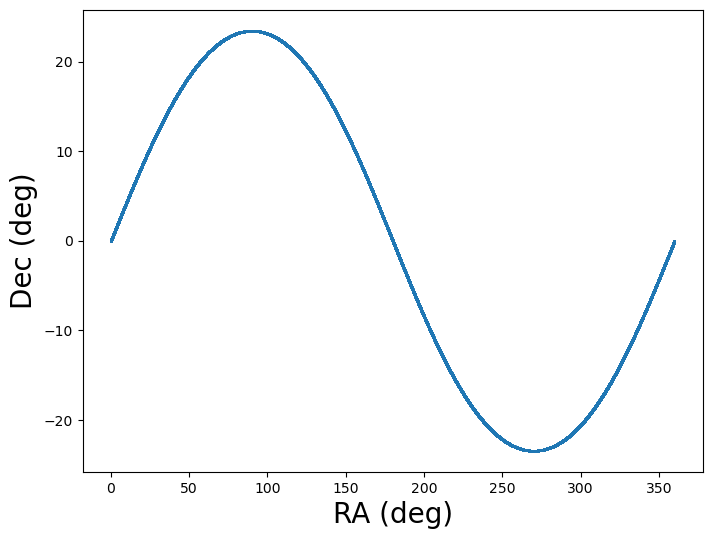

In [143]:
fig = plt.figure(figsize=(8,6))
plt.scatter( df['RA_deg'],df['Dec_deg'],s=1 )
#plt.plot( df['RA_deg'] )
plt.xlabel("RA (deg)",fontsize=20)
plt.ylabel("Dec (deg)",fontsize=20)

In [144]:
try:
    # 步骤 1: 使用 pandas 的 to_datetime 函数进行转换，它能自动识别 '2025-Jan-01' 格式
    datetime_col = pd.to_datetime(df['DateTime_UT'])

    # 步骤 2: 将 pandas 的 datetime 对象传递给 Astropy
    astropy_times_from_pandas = Time(datetime_col, scale='utc')

    # 将结果添加到DataFrame
    df['Astropy_time'] = astropy_times_from_pandas
    
    print("Pandas转换成功！")
    display(df)

except NameError:
    print("错误：请先确保您已经成功创建了名为 'df' 的DataFrame。")
except Exception as e:
    print(f"在转换过程中发生错误: {e}")

Pandas转换成功！


,DateTime_UT,RA_hms,Dec_dms,Diameter_ang,RA_deg,Dec_deg,Astropy_time
0,2025-Jan-01 00:00:00,18 45 33.57,-23 01 29.9,1950.956,281.389875,-23.024972,2025-01-01T00:00:00.000000000
1,2025-Jan-01 00:10:00,18 45 35.40,-23 01 28.0,1950.959,281.397500,-23.024444,2025-01-01T00:10:00.000000000
2,2025-Jan-01 00:20:00,18 45 37.22,-23 01 26.1,1950.962,281.405083,-23.023917,2025-01-01T00:20:00.000000000
3,2025-Jan-01 00:30:00,18 45 39.05,-23 01 24.2,1950.964,281.412708,-23.023389,2025-01-01T00:30:00.000000000
4,2025-Jan-01 00:40:00,18 45 40.88,-23 01 22.3,1950.967,281.420333,-23.022861,2025-01-01T00:40:00.000000000
...,...,...,...,...,...,...,...
52556,2025-Dec-31 23:20:00,18 44 18.53,-23 02 48.2,1950.998,281.077208,-23.046722,2025-12-31T23:20:00.000000000
52557,2025-Dec-31 23:30:00,18 44 20.36,-23 02 46.4,1951.001,281.084833,-23.046222,2025-12-31T23:30:00.000000000
52558,2025-Dec-31 23:40:00,18 44 22.19,-23 02 44.6,1951.003,281.092458,-23.045722,2025-12-31T23:40:00.000000000
52559,2025-Dec-31 23:50:00,18 44 24.02,-23 02 42.7,1951.006,281.100083,-23.045194,2025-12-31T23:50:00.000000000


In [145]:
def save_moon_df_to_binary(df: pd.DataFrame, binary_path: str):
    """
    将月球轨迹DataFrame保存为二进制文件，并返回轨迹坐标用于绘图。
    """
    print("\n--- 开始将DataFrame写入二进制文件 ---")
    print(f"[*] 目标二进制文件: {binary_path}")

    required_cols = ['Astropy_time', 'RA_deg', 'Dec_deg', 'Diameter_ang']
    if not all(col in df.columns for col in required_cols):
        print(f"[!] 错误：DataFrame缺少必需的列。")
        return None

    # ... (二进制打包格式定义不变) ...
    header_packer = struct.Struct('<IQ')
    magic_number = 0x4d455048
    version = 1
    record_count = len(df)
    record_packer = struct.Struct('<dffff')
    
    # 新增：创建列表以收集坐标
    trajectory_points = []

    try:
        with open(binary_path, 'wb') as f_out:
            # ... (写入文件头不变) ...
            header_data = header_packer.pack(version, record_count)
            f_out.write(magic_number.to_bytes(4, 'little'))
            f_out.write(header_data)

            for index, row in df.iterrows():
                # ... (数据提取和坐标转换不变) ...
                julian_date = row['Astropy_time'].jd
                angular_diameter = float(row['Diameter_ang'])
                coord = SkyCoord(ra=row['RA_deg']*u.degree, dec=row['Dec_deg']*u.degree, frame='icrs')
                
                # 逐个获取x,y,z分量
                x = coord.cartesian.x.value
                y = coord.cartesian.y.value
                z = coord.cartesian.z.value
                cartesian_icrs = np.array([x, y, z])
                
                ue_pos = (cartesian_icrs[0], cartesian_icrs[1], cartesian_icrs[2])

                # 新增：将UE坐标点添加到列表中
                trajectory_points.append(ue_pos)
                
                # ... (打包和写入记录不变) ...
                record_data = record_packer.pack(julian_date, ue_pos[0], ue_pos[1], ue_pos[2], angular_diameter)
                f_out.write(record_data)

        print("\n--- 二进制文件写入完成 ---")
        print(f"[*] 成功将 {record_count} 条月球轨迹记录写入到 '{binary_path}'")
        
        # 函数结束时返回收集到的坐标点
        return trajectory_points

    except Exception as e:
        import traceback
        print(f"[!] 写入二进制文件时发生错误: {e}")
        traceback.print_exc()
        return None
    
    
def plot_trajectory_3d(points):
    """
    接收一个坐标点列表并绘制3D轨迹图。
    """
    if not points:
        print("[!] 没有可供绘制的轨迹点。")
        return

    # 将点列表解包为x, y, z三个独立的列表
    x_coords, y_coords, z_coords = zip(*points)

    # 创建3D图像和坐标轴
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # 绘制轨迹线
    ax.plot(x_coords, y_coords, z_coords, label='Solar Sys Object Trajectory')
    
    # 标记起点和终点
    ax.scatter(x_coords[0], y_coords[0], z_coords[0], color='green', s=100, label='Start')
    ax.scatter(x_coords[-1], y_coords[-1], z_coords[-1], color='red', s=100, label='End')

    # 设置坐标轴标签和标题
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.set_title('Solar Sys Object Trajectory in 3D')
    
    # 设置相等的坐标轴比例，使轨迹看起来更像球面上的路径
    ax.set_aspect('equal', adjustable='box')
    
    ax.legend()
    plt.show()


--- 开始将DataFrame写入二进制文件 ---
[*] 目标二进制文件: C:\Users\11020\Downloads\Sun_ephemeris.bin

--- 二进制文件写入完成 ---
[*] 成功将 52561 条月球轨迹记录写入到 'C:\Users\11020\Downloads\Sun_ephemeris.bin'

--- 准备绘制3D轨迹图 ---


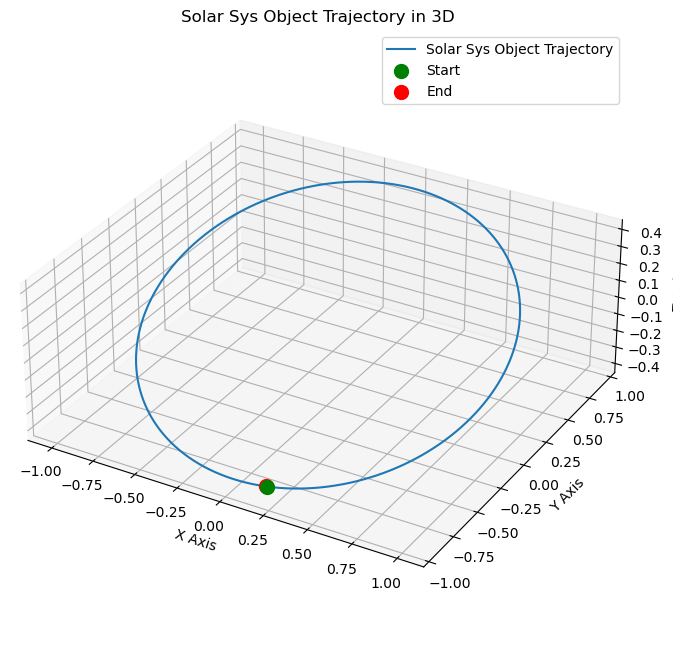

In [146]:
# --- 运行主流程：生成二进制文件并绘图 ---

# 检查 'df' 是否已成功创建
if 'df' in locals() and not df.empty:
    OUTPUT_MOON_BINARY = 'C:\\Users\\11020\\Downloads\\%s_ephemeris.bin'%(object_name)
    
    # 调用函数，它现在会返回轨迹点
    trajectory = save_moon_df_to_binary(df, OUTPUT_MOON_BINARY)
    
    # 如果成功获取了轨迹点，则调用绘图函数
    if trajectory:
        print("\n--- 准备绘制3D轨迹图 ---")
        plot_trajectory_3d(trajectory)
else:
    print("未能运行，因为行星/太阳数据DataFrame ('df') 不存在或为空。")